## Описание проекта, загрузка и подготовка данных

### Введение
______
**Название проекта**  

Определение возраста клиентов по фотофиксации в прикассовой зоне.
_____

**Цель исследования**  

Построение модели, которая по фотографии определит приблизительный возраст человека, с целью:
- анализа покупок и предложения товаров, которые могут заинтересовать покупателей этой возрастной группы;
- контроля добросовестности кассиров при продаже алкоголя.
_______
**Задачи исследования**

- Загрузить и подготовить данные
- Провести исследовательский анализ набора фотографий
- Подготовить данные к обучению
- Обучить нейронную сеть и рассчитать её качество

Значение метрики **MAE** на тестовой выборке должно быть не более **8**
_____
**Исходные данные**  

Данные взяты с сайта `ChaLearn Looking at People` и находятся в папке /datasets/faces/.    
Имеются:
- одна папка со всеми изображениями (/final_files)
- CSV-файл labels.csv с двумя колонками: `file_name` и `real_age`:  

целевой признак:
- `real_age` - возраст клиента

### Установка и импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.resnet import ResNet50

In [2]:
# системные настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
warnings.filterwarnings("ignore")

### Объявление функций

In [3]:
def histbox_plot(df, list_col):
    for name in list_col:
        plt.figure(figsize=(10, 5))
        plt.suptitle('Распределение возраста в выборке', 
                     fontsize=13, fontweight='bold')
       
        # Создание GridSpec для вертикального расположения
        grid = plt.GridSpec(2, 1, height_ratios=[2, 1])
        
        plt.subplot(grid[0])
        sns.histplot(data=df, x=name, kde=True, bins=100)
        plt.xlabel('')
        plt.ylabel('Количество')
        
        # Задание шага подписей по оси X для гистограммы
        max_value = df[name].max()
        min_value = df[name].min() - 1
        step = 5  # Установите нужный вам шаг
        plt.xticks(np.arange(min_value, max_value + step, step))

        plt.subplot(grid[1])
        sns.boxplot(data=df, x=name)
        plt.xlabel('Возраст')
        plt.ylabel('')
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
        
        display(df[name].describe())

### Загрузка данных

In [4]:
labels = pd.read_csv('/datasets/faces/labels.csv')

datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345)

Found 7591 validated image filenames.


## Исследовательский анализ данных

Размер выборки: 7591


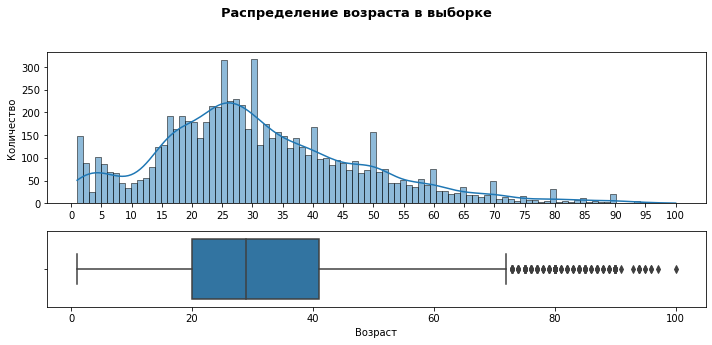

count    7591.000000
mean       31.201159
std        17.145060
min         1.000000
25%        20.000000
50%        29.000000
75%        41.000000
max       100.000000
Name: real_age, dtype: float64

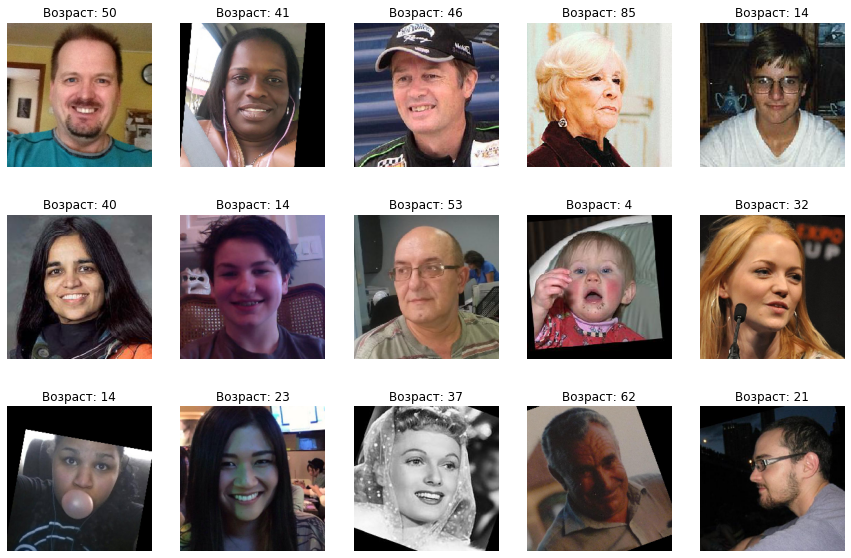

In [5]:
# Размер выборки
print(f"Размер выборки: {datagen_flow.samples}")

# Построение графика распределения возраста
histbox_plot(labels, ['real_age'])

# Печать 15 фотографий с метками возраста
images, ages = next(datagen_flow)

plt.figure(figsize=(15, 10))
for i in range(15): 
    plt.subplot(3, 5, i+1)
    plt.imshow(images[i])
    plt.title(f"Возраст: {int(ages[i])}")
    plt.axis('off')

plt.show()

**Вывод:** размер общей выборки для последующего обучения и тестирования модели составляет 7591 фотографий. В целевом признаке возраст аномальные значения отсутствуют, 50% от общего количества представляют клиенты от 20 до 40 лет, медианный возраст клиента - 29 лет.    
Также на основе гистограммы видно, что количество фотографий увеличивается на "юбилейные" даты (кратные 5, 10), что логично, как правило люди отмечают такие даты с большим размахом и соответственно растет количество фотографий. Также возможной причиной может быть то, что при разметке допускались определенные округления (возможно неосознанные, например разметка осуществлялась "на глазок"). Можно предположить, что из-за этого прогноз возраста будет также тяготеть к таким "круглым" датам (может есть смысл искуственно ограничивать число фотографий по таким "юбилейным" возрастам для более корректного обучения модели).    
Что касается изображений, входящих в датасет, то видно, что имеются как цветные, так и черно-белые фотографии, разной степени освещенности, фотографии с небольшими поворотами рамки изображения, сдвигами изображения относительно центра, а также фотографии, где лица направлены как в правую, так и левую сторону. Исходя из этого разнообразия, необходимо выбрать и соответствующие агументации для обучающего набора, а именно: добавить случайные увеличение/уменьшение яркости изображение, небольшой левый/правый поворот изображения, сдвиг изображения и отражение по горизонтали.

## Обучение модели

Для создания процесса обучения модели будем использовать 4 функции:
 - загрузка тренировочной выборки
 - загрузка тестовой выборки
 - создание модели
 - обучение модели
 
Для загрузки выборок будем использовать динамическую загрузку данных с помощью `ImageDataGenerator`, который будет формировать батчи с изображениями и метками целевого признака. Для обучающей и тестовой выборок создадим разные генераторы, разбиение произведем в соотношении `85:15`.

В части `аугментации` для тренировочной выборки применим отражение по вертикали, сдвиг изображения по горизонтали и вертикали в пределах 20% от ширины и высоты изображения соответственно.

Для обучения модели будем использовать архитектуру `ResNet50`, которая хорошо решает проблему затухающего градиента в глубоких сетях, предобученной на датасете `ImageNet`. С учетом величины нашего датасета будем использовать ResNet50 без "заморозки" весов. 

В качестве алгоритма обучения нейронной сети будем использовать `Adam` со скоростью обучения - 0,0001

В связи с тем, что зачастую нейронные сети с функцией потерь `MSE` обучаются быстрее, будем использовать ее в нашей модели. Для исключения отрицательных прогнозов нашей сети выберем функцию активации `ReLu`.

```python

def load_train(path):
    
    train_datagen = ImageDataGenerator(validation_split=0.15, 
                                     rescale=1./255,
                                     horizontal_flip=True,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2)

    labels = pd.read_csv(path + 'labels.csv')
    train_datagen_flow = train_datagen.flow_from_dataframe(
                                                        dataframe=labels,
                                                        directory=path + 'final_files/',
                                                        x_col='file_name',
                                                        y_col='real_age',
                                                        target_size=(224, 224),
                                                        batch_size=32,
                                                        class_mode='raw',
                                                        subset='training',
                                                        seed=12345)

    return train_datagen_flow
    

def load_test(path):
    
    validation_datagen = ImageDataGenerator(validation_split=0.15,
                                            rescale=1./255)

    labels = pd.read_csv(path + 'labels.csv')
    val_datagen_flow = validation_datagen.flow_from_dataframe(
                                                    dataframe=labels,
                                                    directory=path + 'final_files/',
                                                    x_col='file_name',
                                                    y_col='real_age',
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='raw',
                                                    subset='validation',
                                                    seed=12345)
    
    return val_datagen_flow

def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
              weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
              include_top=False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(loss='mean_squared_error', 
                  optimizer=optimizer, metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)

    return model

```

```
Found 6453 validated image filenames.
Found 1138 validated image filenames.

Train for 202 steps, validate for 36 steps
Epoch 1/10
202/202 - 128s - loss: 228.8780 - mae: 10.8792 - val_loss: 583.4851 - val_mae: 19.1775
Epoch 2/10
202/202 - 118s - loss: 92.6153 - mae: 7.2936 - val_loss: 666.3601 - val_mae: 20.8453
Epoch 3/10
202/202 - 118s - loss: 71.8436 - mae: 6.4810 - val_loss: 323.2833 - val_mae: 13.3777
Epoch 4/10
202/202 - 119s - loss: 57.4660 - mae: 5.7865 - val_loss: 122.0214 - val_mae: 8.2658
Epoch 5/10
202/202 - 118s - loss: 47.7838 - mae: 5.3259 - val_loss: 78.4173 - val_mae: 6.5574
Epoch 6/10
202/202 - 113s - loss: 41.6848 - mae: 4.9600 - val_loss: 73.5376 - val_mae: 6.3291
Epoch 7/10
202/202 - 111s - loss: 36.7400 - mae: 4.6676 - val_loss: 83.0506 - val_mae: 6.6458
Epoch 8/10
202/202 - 111s - loss: 32.7648 - mae: 4.4312 - val_loss: 99.3944 - val_mae: 7.7527
Epoch 9/10
202/202 - 111s - loss: 29.6244 - mae: 4.1822 - val_loss: 69.0689 - val_mae: 6.0993
Epoch 10/10
202/202 - 111s - loss: 26.8516 - mae: 3.9989 - val_loss: 59.3603 - val_mae: 5.7235

36/36 - 6s - loss: 59.3603 - mae: 5.7235
Test MAE: 5.7235
```

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Комментарий ревьюера:
    
    
Модель обучена и преодолела планку требуемой точности. Кстати, по сравнению с многими - отличная метрика! </div>

## Анализ обученной модели

**Общий вывод:**  

**На этапе исследовательского анализа данных:** был определен размер общей выборки для последующего обучения и тестирования модели, который составил 7591 фотографий. В целевом признаке возраст аномальные значения отсутствуют, 50% от общего количества представляют клиенты от `20 до 40` лет, медианный возраст клиента - `29` лет.    
Также на основе гистограммы выяснилось, что количество фотографий увеличивается на "юбилейные" даты (кратные 5, 10), что логично, как правило люди отмечают такие даты с большим размахом и соответственно растет количество фотографий. Можно предположить, что из-за этого прогноз возраста будет также тяготеть к таким "круглым" датам (может есть смысл искуственно ограничивать число фотографий по таким "юбилейным" возрастам для более корректного обучения модели).    
Изображения, входящие в датасет, имеются как цветные, так и черно-белые, разной степени освещенности, фотографии с небольшими поворотами рамки изображения, сдвигами изображения относительно центра, а также фотографии, где лица направлены как в правую, так и левую сторону. Исходя из этого разнообразия, необходимо подбирать и соответствующие агументации для обучающего набора, такие как: увеличение/уменьшение яркости изображение, левый/правый поворот изображения, сдвиг изображения и отражение по горизонтали.

**На этапе обучения модели:**  
Для загрузки выборок использована динамическая загрузка данных с помощью `ImageDataGenerator`. Для обучающей и тестовой выборок созданы разные генераторы, разбиение произведено в соотношении `85/15`.

В части `аугментации` для тренировочной выборки использовано отражение по вертикали, сдвиг изображения по горизонтали и вертикали в пределах 20% от ширины и высоты изображения соответственно.

Для обучения модели использована архитектура `ResNet50`, предобученная на датасете `ImageNet`. С учетом величины нашего датасета использована ResNet50 без "заморозки" весов. В качестве алгоритма обучения нейронной сети использован `Adam` со скоростью обучения - `0,0001`

Также в модели использована функция потерь `MSE` и для исключения отрицательных прогнозов нашей сети выбрана функция активации `ReLu`.
    
По результам обучения модели итоговая метрика после обучения на 10 эпохах составила `MAE = 5.72`, что означает, что в среднем наша модель ошибается при прогнозе возраста клиента на 5.7 лет. С учетом порога ошибки в `8` лет, данную модель можно рекомендовать заказчику. 